In [1]:
from jax import config

config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import jit, lax, nn, random, value_and_grad, vmap

import optax
import matplotlib.pyplot as plt

plt.style.use('bmh')

from boax.core import distributions, samplers
from boax.prediction import models, objectives
from boax.optimization import acquisitions, optimizers

In [2]:
data_key, optimizer_key = random.split(random.key(0))

In [3]:
def objective(x):
    return -((x[..., 0] + 1) ** 2) * jnp.sin(2 * x[..., 0] + 2) / 5 + 1

In [4]:
def approximate(x):
    return 0.5 * objective(x) + x[..., 0] / 4 + 2

In [5]:
bounds = jnp.array([[-5.0, 5.0]])

In [6]:
fidelities = jnp.array([0.5, 1.0])

In [7]:
x_train_values = random.uniform(random.fold_in(data_key, 0), minval=bounds[:, 0], maxval=bounds[:, 1], shape=(10, 1))
x_train_fidelities = random.randint(random.fold_in(data_key, 1), minval=0, maxval=2, shape=(10, 1))

In [8]:
x_train = jnp.concatenate(
    [x_train_values, fidelities[x_train_fidelities]], axis=-1,
)

In [9]:
y_train = jnp.where(
    x_train_fidelities[..., 0],
    objective(x_train_values),
    approximate(x_train_values)
)

In [10]:
xs = jnp.linspace(bounds[:, 0], bounds[:, 1], 501)
ys_true = objective(xs)
ys_approx = approximate(xs)

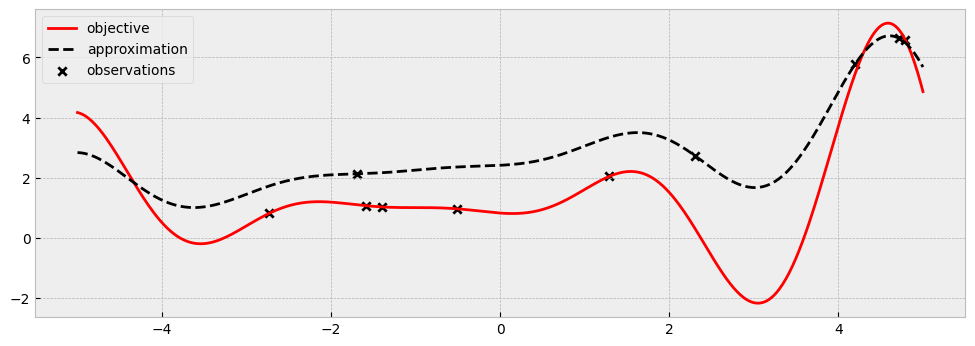

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(xs, ys_true, c='r', label='objective')
ax.plot(xs, ys_approx, c='k', linestyle='--', label='approximation')
ax.scatter(x_train_values, y_train, marker='x', c='k', label='observations')
ax.legend()

plt.show()

In [13]:
def model_fn(params, x_train, y_train):
    return models.multi_fidelity(
        models.means.zero(),
        lambda fid1, fid2: models.kernels.scaled(
            models.kernels.linear_truncated(
                models.kernels.matern_five_halves(nn.softplus(params['unbiased'])),
                models.kernels.matern_five_halves(nn.softplus(params['biased'])),
                nn.softplus(params['power']),
            )(fid1, fid2),
            nn.softplus(params['amplitude']),
        ),
        models.likelihoods.gaussian(nn.softplus(params['noise'])),
        x_train,
        y_train,
    )

In [14]:
def loss_fn(params, x_train, y_train):
    y_hat = model_fn(params, None, None)(x_train)
    
    objective = objectives.penalized(
        objectives.negative_log_likelihood(
            distributions.multivariate_normal.logpdf
        ),
        -jnp.sum(
            distributions.gamma.logpdf(
                distributions.gamma.gamma(2.0, 0.15),
                nn.softplus(params['amplitude']),
            )
        ),
        -jnp.sum(
            distributions.gamma.logpdf(
                distributions.gamma.gamma(3.0, 3.0),
                nn.softplus(params['power']),
            )
        ),
        -jnp.sum(
            distributions.gamma.logpdf(
                distributions.gamma.gamma(3.0, 6.0),
                nn.softplus(params['unbiased']),
            )
        ),
        -jnp.sum(
            distributions.gamma.logpdf(
                distributions.gamma.gamma(6.0, 2.0),
                nn.softplus(params['biased']),
            )
        )
    )

    return objective(y_hat, y_train)

In [16]:
params = {
    'biased': jnp.zeros(()),
    'unbiased': jnp.zeros(()),
    'power': jnp.zeros(()),
    'amplitude': jnp.zeros(()),
    'noise': jnp.zeros(()),
}

In [17]:
adam = optax.adam(0.01)

In [18]:
def fit(x_train, y_train):
    def step(state, i):
        loss, grads = value_and_grad(loss_fn)(state[0], x_train, y_train)
        updates, opt_state = adam.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    (next_params, _), _ = lax.scan(
        jit(step),
        (params, adam.init(params)),
        jnp.arange(500),
    )

    return next_params

In [19]:
y_mean, y_var = jnp.mean(y_train), jnp.var(y_train)
y_norm = nn.standardize(y_train, mean=y_mean, variance=y_var)

In [20]:
next_params = fit(x_train, y_norm)

In [21]:
model = models.scaled(
    models.outcome_transformed(
        model_fn(next_params, x_train, y_norm),
        distributions.mvn_to_norm,
    ),
    distributions.normal.scale,
    loc=y_mean,
    scale=jnp.sqrt(y_var),
)

In [22]:
y_hat = model(jnp.hstack([xs, jnp.ones((501, 1))]))

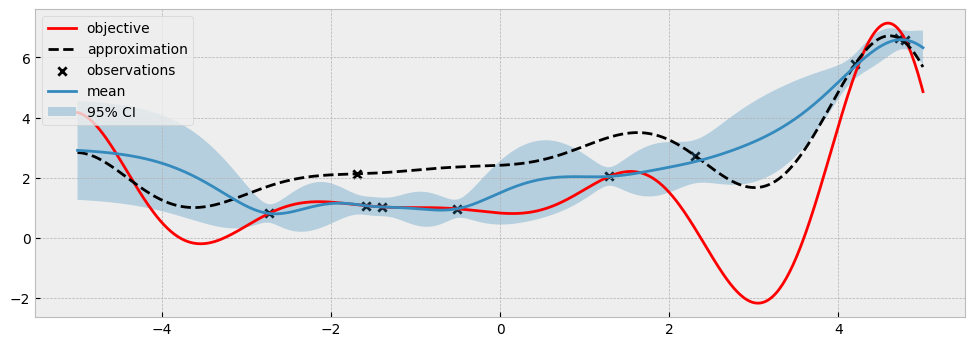

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(xs, ys_true, c='r', label='objective')
ax.plot(xs, ys_approx, c='k', linestyle='--', label='approximation')
ax.scatter(x_train_values, y_train, marker='x', c='k', label='observations')

ax.plot(xs, y_hat.loc, label='mean')
ax.fill_between(
    xs.flatten(),
    y_hat.loc - 2 * y_hat.scale,
    y_hat.loc + 2 * y_hat.scale,
    alpha=0.3,
    label='95% CI'
)

ax.legend(loc='upper left')

plt.show()

In [26]:
def cost(x):
    return 10 + x[..., 1]

In [32]:
model_cost = models.joined(
    model,
    cost,
)

In [42]:
key1, key2 = random.split(random.key(0))
s, n = 32, 10

best = 0.0
loc, scale = random.uniform(key1, (2, n, s, 1))
cost = random.uniform(key2, (n,))
preds = distributions.normal.normal(loc, scale)

In [47]:
cost.shape

(10,)

In [46]:
jnp.squeeze(preds.loc - best, axis=-1).shape

(10, 32)

In [53]:
jnp.mean((jnp.squeeze(preds.loc - best, axis=-1) / cost[..., jnp.newaxis]), axis=-1)

Array([0.73711553, 1.26476817, 0.92278978, 0.68727337, 0.50606529,
       0.67834267, 0.86699063, 0.61253229, 1.11807063, 2.28338359],      dtype=float64)